# Result validation notebook

In [1]:
#analyte_nr = 638 # Troponin-T-hs,TNThsn,67151-1 (predictive)
analyte_nr = 3 # Kalium,KA,2823-3



# MI
diagnosis_code_min = 200
diagnosis_code_max = 259

In [2]:
import pandas as pd

chunk_size = 10000000 # 10M rows per chunk
lab_data_df = None

rows_processed = chunk_size
for chunk in pd.read_csv("../data/raw/20181218_case_lab_data.csv", chunksize=chunk_size, delimiter=';', encoding='Latin-1'):  # Time: O(chunk_qty * chunksize), Size: O(1)
        chunk = chunk.drop(["ERMITTLUNG"], axis=1)
        chunk = chunk[chunk["ANALYSE"] == analyte_nr]
        if lab_data_df is None:                                             # if this is the first pivotation chunk, keep it as is
            lab_data_df = chunk
        else:                                                               # else, combine the former table with the new chunk
            lab_data_df = lab_data_df.combine_first(chunk)
            print(str(rows_processed) + " lab value rows processed.")
            rows_processed += chunk_size
            

10000000 lab value rows processed.
20000000 lab value rows processed.
30000000 lab value rows processed.
40000000 lab value rows processed.
50000000 lab value rows processed.


In [3]:
import numpy as np
case_diagnosis_df = None
rows_processed = 0
next_rows_threshold = 0

drop_dot = str.maketrans("1234567890", "1234567890", '.')
inclusion_labels = {'I' + str(number) for number in range(diagnosis_code_min, diagnosis_code_max)}  # range of ICD10 codes for positive diagnosis

# read diagnoses of cases
for chunk in pd.read_csv("../data/raw/20181218_case_diagnosis_data.csv", chunksize=chunk_size, delimiter=';'):  # Time: O(chunk_qty * chunksize), Size: O(1)
    diagnosis_list_df = chunk.groupby("CASEPSEUDOID")["DKEY1"].apply(list).to_frame()

    # merge new diagnoses with old ones
    if case_diagnosis_df is None:
        case_diagnosis_df = diagnosis_list_df
    else:
        case_diagnosis_df = pd.merge(case_diagnosis_df, diagnosis_list_df, on='CASEPSEUDOID', sort=False, how='outer')

        # fill Nan with empty lists
        case_diagnosis_df["DKEY1_x"] = case_diagnosis_df["DKEY1_x"].apply(lambda d: d if isinstance(d, list) else [])
        case_diagnosis_df["DKEY1_y"] = case_diagnosis_df["DKEY1_y"].apply(lambda d: d if isinstance(d, list) else [])

        case_diagnosis_df['DKEY1'] = case_diagnosis_df['DKEY1_x'] + case_diagnosis_df['DKEY1_y']    # combine
        case_diagnosis_df = case_diagnosis_df.drop(['DKEY1_x', 'DKEY1_y'], axis=1)

    if isinstance(case_diagnosis_df['DKEY1'][0], (list, tuple)):  # remove dots from icd10 codes
        case_diagnosis_df['DKEY1'] = case_diagnosis_df['DKEY1'].map(lambda d: {icd.translate(drop_dot) for icd in d})
    else:
        case_diagnosis_df['DKEY1'] = case_diagnosis_df['DKEY1'].map(lambda d: d.translate(drop_dot))

    case_diagnosis_df['diagnostic_outcome'] = np.where(case_diagnosis_df['DKEY1'].map(lambda d: inclusion_labels.intersection(d) != set()), 1, 0)  # 0,1 encode diagnosis

    rows_processed += chunk_size

    # log progress periodically
    if rows_processed > next_rows_threshold:
        print(str(next_rows_threshold) + " diagnosis rows processed.")
        next_rows_threshold += chunk_size

# join panda dfs
case_lab_diagnosis_df = lab_data_df.join(case_diagnosis_df, on="CASEPSEUDOID", how='inner')

0 diagnosis rows processed.


In [4]:
case_lab_diagnosis_df

,CASEPSEUDOID,ANALYSE,WERT,EINHEIT,BEZ,KBZ,LOINC,DKEY1,diagnostic_outcome
2945,CAFDE5122B5F461CE993106F19B513DE8660AF26A6F102...,3.0,3.4,mmol/L,Kalium,KA,2823-3,"{I1090, M146, R455, E871, E876, E1173, G632, E...",0
26880759,CAFDE5122B5F461CE993106F19B513DE8660AF26A6F102...,3.0,3.9,mmol/L,Kalium,KA,2823-3,"{I1090, M146, R455, E871, E876, E1173, G632, E...",0
28699229,CAFDE5122B5F461CE993106F19B513DE8660AF26A6F102...,3.0,3.4,mmol/L,Kalium,KA,2823-3,"{I1090, M146, R455, E871, E876, E1173, G632, E...",0
43262705,CAFDE5122B5F461CE993106F19B513DE8660AF26A6F102...,3.0,3.1,mmol/L,Kalium,KA,2823-3,"{I1090, M146, R455, E871, E876, E1173, G632, E...",0
2946,8647E914373111871EB8BA15497250F066430ACCF85EDD...,3.0,3.3,mmol/L,Kalium,KA,2823-3,"{E876, R650, T827, I5013, Y849, I513, I739, Z9...",0
555627,8647E914373111871EB8BA15497250F066430ACCF85EDD...,3.0,3.4,mmol/L,Kalium,KA,2823-3,"{E876, R650, T827, I5013, Y849, I513, I739, Z9...",0
2030194,8647E914373111871EB8BA15497250F066430ACCF85EDD...,3.0,3.6,mmol/L,Kalium,KA,2823-3,"{E876, R650, T827, I5013, Y849, I513, I739, Z9...",0
2546385,8647E914373111871EB8BA15497250F066430ACCF85EDD...,3.0,3.8,mmol/L,Kalium,KA,2823-3,"{E876, R650, T827, I5013, Y849, I513, I739, Z9...",0
3972134,8647E914373111871EB8BA15497250F066430ACCF85EDD...,3.0,3.4,mmol/L,Kalium,KA,2823-3,"{E876, R650, T827, I5013, Y849, I513, I739, Z9...",0
6094624,8647E914373111871EB8BA15497250F066430ACCF85EDD...,3.0,3.5,mmol/L,Kalium,KA,2823-3,"{E876, R650, T827, I5013, Y849, I513, I739, Z9...",0


c:\users\i0325777\appdata\local\continuum\miniconda3\envs\computational_diagnostic_paths\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


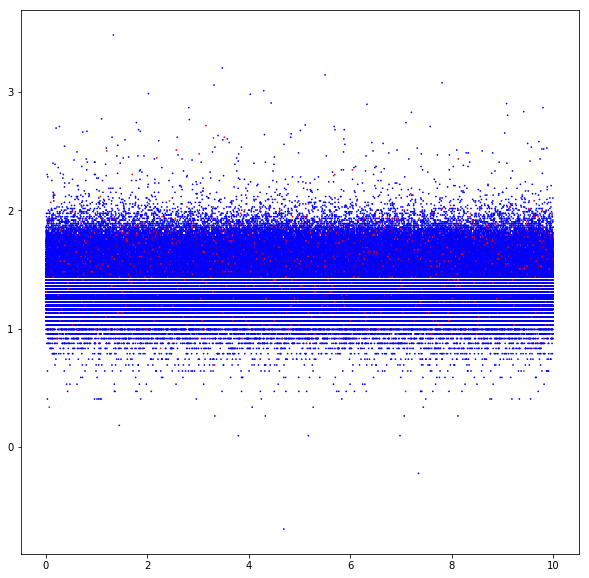

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))

plt.scatter(10 * np.random.uniform(size=len(case_lab_diagnosis_df)), np.log(case_lab_diagnosis_df["WERT"]), c=np.sign(case_lab_diagnosis_df['diagnostic_outcome']), cmap="bwr", s=0.5)

plt.show()

In [6]:
print("Size of dataset:" + str(len(case_lab_diagnosis_df)))
positive_samples = case_lab_diagnosis_df[case_lab_diagnosis_df['diagnostic_outcome'] == 1]
negative_samples = case_lab_diagnosis_df[case_lab_diagnosis_df['diagnostic_outcome'] == 0]
print("Size of positive samples in ds:" + str(len(positive_samples)))
print("Size of negative samples in ds:" + str(len(negative_samples)))
print("Ratio: "+ str(len(positive_samples)/len(negative_samples)))

Size of dataset:905494
Size of positive samples in ds:67696
Size of negative samples in ds:837798
Ratio: 0.08080229363163913


In [7]:
# Description: Train linear regression model to predict outcome
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import shuffle


if True: # balance dataset
    positive_samples_qty = len(positive_samples)
    case_lab_diagnosis_df = pd.concat([positive_samples, negative_samples[:positive_samples_qty]])
else:
    case_lab_diagnosis_df = lab_data_df.join(case_diagnosis_df, on="CASEPSEUDOID", how='inner')

train_test_split = 0.8
size = len(case_lab_diagnosis_df)
case_lab_diagnosis_df = shuffle(case_lab_diagnosis_df)

# Split the data into training/testing sets
X_train = case_lab_diagnosis_df["WERT"][:int(size * train_test_split)].values.reshape(-1, 1)
X_test = case_lab_diagnosis_df["WERT"][int(size * train_test_split):].values.reshape(-1, 1)

# Split the targets into training/testing sets
y_train = case_lab_diagnosis_df['diagnostic_outcome'][:int(size * train_test_split)]
y_test = case_lab_diagnosis_df['diagnostic_outcome'][int(size * train_test_split):]

model = linear_model.LogisticRegression(C=1e20)
model.fit(X_train, y_train)
#model.fit(np.random.uniform(size=len(y_train)).reshape(-1, 1), y_train) # compared to random chance
preds = model.predict(X_test)
# accuracy
print("Accuracy:" + str((preds == y_test).mean()))

Accuracy:0.5120942427711511
